# 1. Q&A アプリケーション

In [6]:
import os

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"
os.environ["LANGCHAIN_PROJECT"]="AI-Agent"

## ロールの定義

In [7]:
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確でわかりやすい回答を提供してください。"
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。"
    },
    "3": {
    "name": "カウンセラー",
    "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
    "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。"
    }
}

## ステートの定義

In [4]:
import operator
from typing import Annotated

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph

class State(BaseModel):
    query: str = Field(
        ..., 
        description="ユーザーからの質問"
    )
    current_role: str = Field(
        default="", 
        description="選定された回答ロール"
    )
    messages: Annotated[list[str], operator.add] = Field(
        default=[], 
        description="回答履歴"
    )
    current_judge: bool = Field(
        default=False,
        description="品質チェックの結果"
    )
    judgement_reason: str = Field(
        default="",
        description="品質チェックの判定理由"
    )

## Chat modelの初期化

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField

llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

# 後からmax_tokensの値を変更できるように、変更可能なフィールドを宣言
llm = llm.configurable_fields(max_tokens=ConfigurableField(id="max_tokens"))

## ノードの定義

### Selectionノード

In [11]:
from typing import Any
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def selection_node(state: State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join([f"{k}. {v['name']}: {v['description']}" for k, v in ROLES.items()])
    prompt = ChatPromptTemplate.from_template(
    """
    質問を分析し、最も適切な回答担当ロールを選択してください。

    選択肢：
    {role_options}

    回答は選択肢の番号(1, 2, または3)のみを返してください。

    質問： {query}
    """.strip() # .strip()で文字列の空白やスペースを削除
    )

    # 選択肢の番号のみを返すことを期待したいため、max_tokensの値を1に変更
    chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})

    selected_role = ROLES[role_number.strip()]["name"]
    return {"current_role": selected_role}

### Answeringノード

In [12]:
def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])
    prompt = ChatPromptTemplate.from_template(
    """
    あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

    役割の詳細：{role_details}

    質問：{query}

    回答：
    """.strip()
    )

    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})
    return {"messages": [answer]}

### Checkノード

In [13]:
class Judgement(BaseModel):
    reason: str = Field(
        default="",
        description="判定理由"
    )
    judge: bool = Field(
        default=False,
        description="判定結果"
    )

def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]
    prompt = ChatPromptTemplate.from_template(
    """
    以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。また、その判断理由も説明してください。

    ユーザーからの質問： {query}
    回答： {answer}
    """.strip()
    )
    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {"current_judge": result.judge, "judgement_reason": result.reason}

## グラフの作成

In [15]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

## ノードの追加

In [16]:
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)

## エッジの定義

In [17]:
# selectionノードから処理を開始
workflow.set_entry_point("selection")

# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")

# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")

## 条件付きエッジの定義

In [18]:
from langgraph.graph import END

# checkノードから次のノードへの遷移に条件付きエッジを定義
# state.current_judgeの値がTrueならENDノードへ、Falseならselectionノードへ
workflow.add_conditional_edges(
    "check",
    lambda state: state.current_judge,
    {True: END, False: "selection"}
)

## グラフのコンパイル

In [19]:
compiled = workflow.compile()

## グラフの実行

In [20]:
initial_state = State(query="生成AIについて教えてください")
result = compiled.invoke(initial_state)

In [24]:
import pprint
pprint.pprint(result)

{'current_judge': True,
 'current_role': '生成AI製品エキスパート',
 'judgement_reason': '回答は生成AIについての基本的な情報を網羅しており、自然言語処理、画像生成、音声合成などの具体例を挙げて説明しています。また、生成AIの応用分野や倫理的な課題についても触れており、バランスの取れた内容です。特に誤った情報や不正確な記述は見当たらず、全体として質の高い回答と判断できます。',
 'messages': ['生成AI（生成的人工知能）とは、人工知能の一分野であり、新しいデータやコンテンツを生成する能力を持つモデルやシステムを指します。これには、テキスト、画像、音声、音楽、ビデオなど、さまざまな形式のコンテンツが含まれます。生成AIの代表的な技術には、以下のようなものがあります。\n'
              '\n'
              '1. **自然言語処理（NLP）モデル**: 例えば、GPT（Generative Pre-trained '
              'Transformer）シリーズは、テキストの生成や翻訳、要約などに利用されます。これらのモデルは、大量のテキストデータを学習し、人間のように自然な文章を生成することができます。\n'
              '\n'
              '2. **画像生成モデル**: GAN（Generative Adversarial '
              'Networks）やVAE（Variational '
              'Autoencoders）などの技術を用いて、新しい画像を生成することができます。これにより、アート作品の創作や、現実には存在しない人物の顔を生成することが可能です。\n'
              '\n'
              '3. **音声合成**: '
              'TTS（Text-to-Speech）技術を用いて、テキストから自然な音声を生成することができます。これにより、音声アシスタントやナレーションの自動生成が可能になります。\n'
              '\n'
              '生成AIは、クリエイ

In [22]:
print(result["messages"][-1])

生成AI（生成的人工知能）とは、人工知能の一分野であり、新しいデータやコンテンツを生成する能力を持つモデルやシステムを指します。これには、テキスト、画像、音声、音楽、ビデオなど、さまざまな形式のコンテンツが含まれます。生成AIの代表的な技術には、以下のようなものがあります。

1. **自然言語処理（NLP）モデル**: 例えば、GPT（Generative Pre-trained Transformer）シリーズは、テキストの生成や翻訳、要約などに利用されます。これらのモデルは、大量のテキストデータを学習し、人間のように自然な文章を生成することができます。

2. **画像生成モデル**: GAN（Generative Adversarial Networks）やVAE（Variational Autoencoders）などの技術を用いて、新しい画像を生成することができます。これにより、アート作品の創作や、現実には存在しない人物の顔を生成することが可能です。

3. **音声合成**: TTS（Text-to-Speech）技術を用いて、テキストから自然な音声を生成することができます。これにより、音声アシスタントやナレーションの自動生成が可能になります。

生成AIは、クリエイティブなプロセスを支援し、効率を向上させるために多くの分野で活用されています。例えば、広告やマーケティング、ゲーム開発、映画制作、教育などでの応用が進んでいます。しかし、生成AIの利用には倫理的な課題も伴います。例えば、偽情報の生成や著作権の問題などが挙げられます。これらの課題に対処するためには、技術の透明性や責任ある利用が求められています。

生成AIは急速に進化しており、今後も新しい応用や技術革新が期待されています。


## グラフ構造の可視化

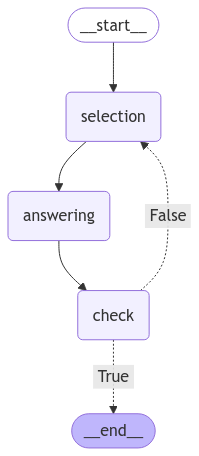

In [30]:
from IPython.display import Image
import nest_asyncio

nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(Image(compiled.get_graph().draw_mermaid_png()))

# 2. チェックポイントの動作確認

In [31]:
import os 

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"
os.environ["LANGCHAIN_PROJECT"]="AI-Agent"

## ステートとノードの定義
- query : ユーザー入力を受け付けるフィールド
- messages : ユーザーとLLMとの会話履歴を保持するフィールド。SystemMessageやHumanMessageなどのBaseMessageをリスト化し、operator.addでそれらをどんどん追加していくイメージ。
- add_message関数 : 受け取ったqueryをmessagesに追加する
- llm_response関数 : messagesの内容を元にLLMに応答させ、結果をmessagesに追加する

In [33]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# ステートの定義
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])

# メッセージを追加するノード関数
def add_message(state: State) -> dict[str, Any]:
    additional_messages = []
    if not state.messages:
        additional_messages.append(
            SystemMessage(content="あなたは最小限の応答をする対話エージェントです。")
        )
    additional_messages.append(HumanMessage(content=state.query))
    return {"messages": additional_messages}

# LLMからの応答を追加するノード関数
def llm_response(state: State) -> dict[str, Any]:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    ai_message = llm.invoke(state.messages)
    return {"messages": [ai_message]}

## チェックポイントの内容を表示する関数を定義
- チェックポインタのインスタンスから最新のCheckpointTupleを取得し、その中のCheckpoint情報とMetadata情報を表示

In [35]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver

def print_checkpoint_dump(checkpoint: BaseCheckpointSaver, confing: RunnableConfig):
    checkpoint_tuple = checkpoint.get_tuple(config)

    print("チェックポイントデータ：")
    pprint(checkpoint_tuple.checkpoint)
    print("")
    print("\nメタデータ：")
    pprint(checkpoint_tuple.metadata)

## グラフの定義とコンパイル
- グラフのコンパイル時にチェックポインタのインスタンスをオプションとして渡す

In [37]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# グラフを設定
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)

# チェックポインタを設定
checkpointer = MemorySaver()

# グラフをコンパイル
compiled_graph = graph.compile(checkpointer=checkpointer)

## グラフ構造の可視化

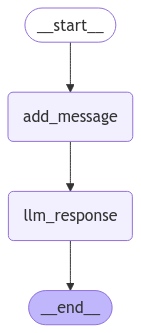

In [38]:
from IPython.display import Image
import nest_asyncio

nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

## 実行＆動作確認
- "thread_id"でグラフ同士の実行セッションを区別する
   - 例えば、AさんとBさんがそれぞれ実行したグラフのチェックポイントを別々に保持するための識別子

In [40]:
config = {"configurable": {"thread_id": "example-1"}}
user_query = State(query="私が好きなものはびっくりドンキーのハンバーグです。覚えておいてね。")
first_response = compiled_graph.invoke(user_query, config)
first_response

{'query': '私が好きなものはびっくりドンキーのハンバーグです。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私が好きなものはびっくりドンキーのハンバーグです。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました！びっくりドンキーのハンバーグですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 55, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-8c1d9054-61c3-46b6-a71e-bb9008a2dba9-0', usage_metadata={'input_tokens': 55, 'output_tokens': 18, 'total_tokens': 73})]}

### チェックポインタの情報の変化を確認
- "__ start __"キーに呼び出しステートが設定される

In [41]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1efca1f0-96ba-6f20-8002-0088b00c242e'}}, checkpoint={'v': 1, 'ts': '2025-01-03T22:06:52.262377+00:00', 'id': '1efca1f0-96ba-6f20-8002-0088b00c242e', 'channel_values': {'query': '私が好きなものはびっくりドンキーのハンバーグです。覚えておいてね。', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私が好きなものはびっくりドンキーのハンバーグです。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました！びっくりドンキーのハンバーグですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 55, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b',

### 最新のチェックポイントの詳細データ

In [42]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ：
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私が好きなものはびっくりドンキーのハンバーグです。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました！びっくりドンキーのハンバーグですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 55, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-8c1d9054-61c3-46b6-a71e-bb9008a2dba9-0', usage_metadata={'input_tokens': 55, 'output_tokens': 18, 'total_tokens': 73

### 再度グラフを実行し、過去の記憶をたどる

In [43]:
user_query = State(query="私の好物は何か覚えてる？")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '私の好物は何か覚えてる？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私が好きなものはびっくりドンキーのハンバーグです。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました！びっくりドンキーのハンバーグですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 55, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-8c1d9054-61c3-46b6-a71e-bb9008a2dba9-0', usage_metadata={'input_tokens': 55, 'output_tokens': 18, 'total_tokens': 73}),
  HumanMessage(content='私の好物は何か覚えてる？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='はい、びっくりドンキー

### 再度チェックポインタの情報の変化を確認
- 2回目実行時の履歴も保存されていることがわかる

In [44]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1efca206-4440-65f2-8006-8507dc1c4fc5'}}, checkpoint={'v': 1, 'ts': '2025-01-03T22:16:34.171851+00:00', 'id': '1efca206-4440-65f2-8006-8507dc1c4fc5', 'channel_values': {'query': '私の好物は何か覚えてる？', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私が好きなものはびっくりドンキーのハンバーグです。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました！びっくりドンキーのハンバーグですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 55, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'st

In [45]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ：
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私が好きなものはびっくりドンキーのハンバーグです。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました！びっくりドンキーのハンバーグですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 55, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-8c1d9054-61c3-46b6-a71e-bb9008a2dba9-0', usage_metadata={'input_tokens': 55, 'output_tokens': 18, 'total_tokens': 73

### thread_idを変えて実行してみる
- "thread_id"が違うため、これまでの会話の履歴がない

In [46]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="私の好物は何？")
other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response

{'query': '私の好物は何？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は何？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりません。あなたの好物は何ですか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 36, 'total_tokens': 51, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-fd3d0bc5-1f5f-4785-873b-bc1f8ad3e0be-0', usage_metadata={'input_tokens': 36, 'output_tokens': 15, 'total_tokens': 51})]}